In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import os
from mido.midifiles.meta import KeySignatureError
from mido import MidiFile
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from functools import partial
from copy import deepcopy
from base import BaseModel
from datasets import load_rolls, MotifDataset, roll_to_monoroll
from models import MusicTransformer

There were 486 rolls with non-4/4 signatures
834 rolls were loaded from 910 files


<AxesSubplot:>

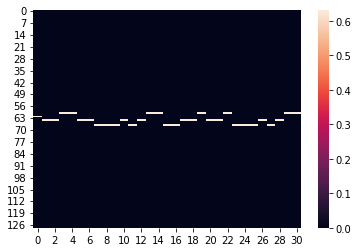

In [2]:
test_path = 'samples/music/flute/'
rolls = load_rolls(test_path)
sn.heatmap(rolls[12])

In [3]:
motif_size = 32
bits = 16
paths = [
    # 'samples/music/giantpiano/',
    'samples/music/flute/',
    # 'samples/music/jazz/',
#     'samples/music/maestro/',
    # 'samples/music/mfiles/',
    # 'samples/music/midiworld/',
]
dataset = MotifDataset(paths, motif_size=motif_size, bits=bits, notespbeat=20, multitokens=False)

MetaMessage('key_signature', key='A', time=0)
MetaMessage('key_signature', key='A', time=0)
MetaMessage('key_signature', key='A', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signature', key='F', time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='F', time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='G', time=0)
MetaMessage('key_signature', key='Ab', time=1441)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('key_signature', key='Bb', time=0)
MetaMessage('key_signat

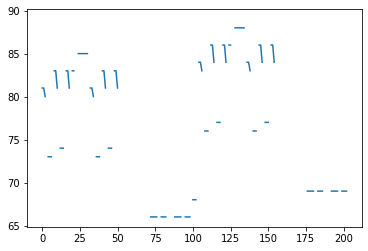

In [10]:
r = dataset.rolls[88]
# sn.heatmap(r)
r = roll_to_monoroll(r)
r = [x if x > 0 else np.nan for x in r]
plt.plot(range(len(r)), r)

In [7]:
r = dataset.rolls[88]
r.shape
dataset.keys[88]

'F'

In [6]:
# batch_size = 32

# net_multi = MusicTransformer(encoder_depth=128, decoder_depth=128, multitokens=True, heads=16)
# n_param = sum(
#     # p.numel() for p in net_multi.parameters() if p.requires_grad
# )
# print('Network ready {:d} parameters'.format(n_param))

# dataset.multitokens = True
# train_loader = DataLoader(
#     dataset, batch_size, True, num_workers=1
# )
# val_loader = DataLoader(
#     dataset, batch_size, num_workers=1
# )

# net_multi.fit(train_loader, val_loader, epochs=10, patience=10)